In [1]:
import pandas as pd
import numpy as np

from hazm import *
from hazm import stopwords_list
import nlpaug.augmenter.word as naw

from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

In [2]:
#Read dataset
df=pd.read_excel("dishwasher.xlsx")
df.head(5)

,Brand,Name,Author_name,Date,Offer,Store_name,Model,Comment,کلی#مثبت,کلی#منفی,...,رابط کاربری#منفی,مصرف انرژی#مثبت,مصرف انرژی#منفی,برنامه‌های شست و شو # مثبت,برنامه‌های شست و شو#منفی,مشخصات فیزیکی#مثبت,مشخصات فیزیکی#منفی,کیفیت#مثبت,کیفیت#منفی,خنثی
0,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,کاربر دیجیکالا,۱ ماه پیش,پیشنهاد می‌کنم,دلا کالا نوین,سفید,دو تا سبد داره، نصف شور داره، پنج تا برنامه دا...,0,0,...,0,0,0,1,0,0,0,0,0,0
1,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,محسن خلیلی جعفرآبادی,۱ ماه پیش,پیشنهاد می‌کنم,دیجی‌کالا,سفید,دستگاه مشکلی نداشت اما تحویل دیجی کالا باید تو...,0,0,...,0,0,0,0,0,0,0,0,0,0
2,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,سمیه اقبال,۲ ماه پیش,پیشنهاد می‌کنم,فروشگاه هاتف جعفری,سفید,کارش عالیه و خوب میشوره و برق میندازه ممنون از...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,کاربر دیجیکالا,۲ ماه پیش,پیشنهاد می‌کنم,آفر سنتر ایلیا,سفید,نسبت به قیمت خوب و بعد از کلی بررسی این ماشینو...,1,0,...,0,0,0,0,0,0,0,0,0,0
4,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,محسن رضازادهءکلاهکاری,۲ ماه پیش,پیشنهاد می‌کنم,آفر سنتر ایلیا,سفید,خوب بود,1,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Check columns that contain aspects
bolean_cols=df.columns[8:]
bolean_cols

Index(['کلی#مثبت', 'کلی#منفی', 'عملکرد#مثبت', 'عملکرد#منفی', 'دیجی کالا#مثبت',
       'دیجی کالا#منفی', 'قیمت#مثبت', 'قیمت#منفی', 'گارانتی#مثبت',
       'گارانتی#منفی', 'خدمات پس از فروش#مثبت', 'خدمات پس از فروش#منفی',
       'میزان صدا و لرزش#مثبت', 'میزان صدا و لرزش#منفی', 'رابط کاربری#مثبت',
       'رابط کاربری#منفی', 'مصرف انرژی#مثبت', 'مصرف انرژی#منفی',
       'برنامه‌های شست و شو # مثبت', 'برنامه‌های شست و شو#منفی',
       'مشخصات فیزیکی#مثبت', 'مشخصات فیزیکی#منفی', 'کیفیت#مثبت', 'کیفیت#منفی',
       'خنثی'],
      dtype='object')

In [4]:
for col in bolean_cols:
    df[col]=df[col].astype(int)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Brand                       871 non-null    object
 1   Name                        871 non-null    object
 2   Author_name                 871 non-null    object
 3   Date                        871 non-null    object
 4   Offer                       871 non-null    object
 5   Store_name                  871 non-null    object
 6   Model                       871 non-null    object
 7   Comment                     871 non-null    object
 8   کلی#مثبت                    871 non-null    int32 
 9   کلی#منفی                    871 non-null    int32 
 10  عملکرد#مثبت                 871 non-null    int32 
 11  عملکرد#منفی                 871 non-null    int32 
 12  دیجی کالا#مثبت              871 non-null    int32 
 13  دیجی کالا#منفی              871 non-null    int32 

In [6]:
# Check the number of cells equal to 1 in each column
def count_col(filtred_columns):
    tmp={}
    for column in filtred_columns.columns:
        count_ones = (filtred_columns[column] == 1).sum()
        tmp[column]=count_ones
    return tmp

In [7]:
#Columns containing aspects
filtred_columns = df.iloc[:, 8:]
filtred_columns

,کلی#مثبت,کلی#منفی,عملکرد#مثبت,عملکرد#منفی,دیجی کالا#مثبت,دیجی کالا#منفی,قیمت#مثبت,قیمت#منفی,گارانتی#مثبت,گارانتی#منفی,...,رابط کاربری#منفی,مصرف انرژی#مثبت,مصرف انرژی#منفی,برنامه‌های شست و شو # مثبت,برنامه‌های شست و شو#منفی,مشخصات فیزیکی#مثبت,مشخصات فیزیکی#منفی,کیفیت#مثبت,کیفیت#منفی,خنثی
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
869,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
count_col(filtred_columns)

{'کلی#مثبت': 459,
 'کلی#منفی': 44,
 'عملکرد#مثبت': 202,
 'عملکرد#منفی': 22,
 'دیجی کالا#مثبت': 123,
 'دیجی کالا#منفی': 59,
 'قیمت#مثبت': 107,
 'قیمت#منفی': 9,
 'گارانتی#مثبت': 11,
 'گارانتی#منفی': 6,
 'خدمات پس از فروش#مثبت': 66,
 'خدمات پس از فروش#منفی': 29,
 'میزان صدا و لرزش#مثبت': 58,
 'میزان صدا و لرزش#منفی': 16,
 'رابط کاربری#مثبت': 9,
 'رابط کاربری#منفی': 1,
 'مصرف انرژی#مثبت': 6,
 'مصرف انرژی#منفی': 1,
 'برنامه\u200cهای شست و شو # مثبت': 29,
 'برنامه\u200cهای شست و شو#منفی': 4,
 'مشخصات فیزیکی#مثبت': 41,
 'مشخصات فیزیکی#منفی': 39,
 'کیفیت#مثبت': 76,
 'کیفیت#منفی': 15,
 'خنثی': 30}

In [9]:
#Check the number of samples in each class
def plot_bar_chart(data):
    # Correct display of Persian texts
    labels = [get_display(arabic_reshaper.reshape(key)) for key in data.keys()]
    plt.figure(figsize=(10, 5))
    plt.bar(labels, data.values())
    plt.xlabel(get_display(arabic_reshaper.reshape("نام کلاس")))
    plt.ylabel(get_display(arabic_reshaper.reshape("تعداد نمونه")))
    # plt.title(get_display(arabic_reshaper.reshape("نمودار میله‌ای از دیکشنری داده شده")))
    plt.xticks(rotation=45, ha="right")
    plt.show()

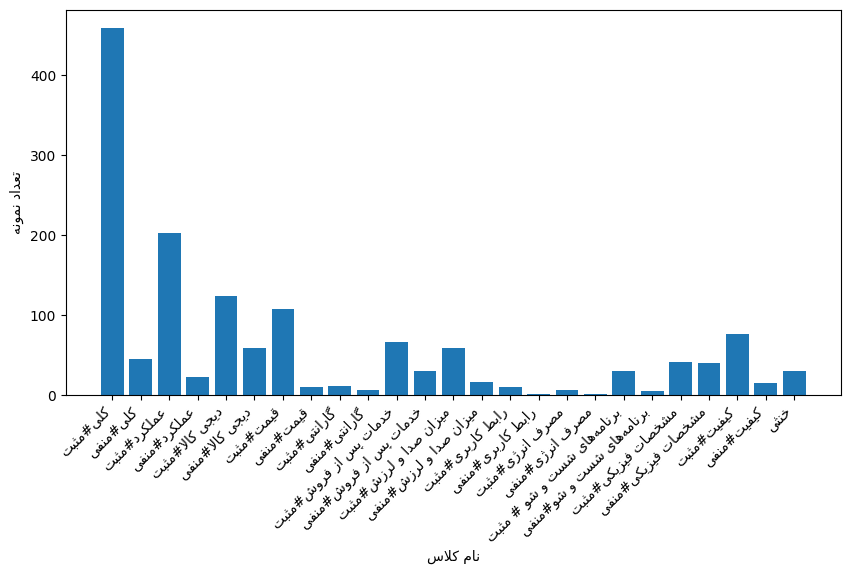

In [10]:
plot_bar_chart(count_col(filtred_columns))

In [11]:
# Identifying minority labels
def minority_colms(df,filtred_columns,threshold):
    minority_columns={}
    for column in filtred_columns:
        count_ones = (df[column] == 1).sum()
        if count_ones<threshold:
                minority_columns[column]=count_ones
    return minority_columns

In [12]:
minority_colms(df,filtred_columns,20)

{'قیمت#منفی': 9,
 'گارانتی#مثبت': 11,
 'گارانتی#منفی': 6,
 'میزان صدا و لرزش#منفی': 16,
 'رابط کاربری#مثبت': 9,
 'رابط کاربری#منفی': 1,
 'مصرف انرژی#مثبت': 6,
 'مصرف انرژی#منفی': 1,
 'برنامه\u200cهای شست و شو#منفی': 4,
 'کیفیت#منفی': 15}

In [13]:
# Specify labels with a limited number of instances to delete
cols=df.columns
indices_to_remove = [16,17,22,23,24,25]
cols = [cols[i] for i in range(len(cols)) if i not in indices_to_remove]
cols

['Brand',
 'Name',
 'Author_name',
 'Date',
 'Offer',
 'Store_name',
 'Model',
 'Comment',
 'کلی#مثبت',
 'کلی#منفی',
 'عملکرد#مثبت',
 'عملکرد#منفی',
 'دیجی کالا#مثبت',
 'دیجی کالا#منفی',
 'قیمت#مثبت',
 'قیمت#منفی',
 'خدمات پس از فروش#مثبت',
 'خدمات پس از فروش#منفی',
 'میزان صدا و لرزش#مثبت',
 'میزان صدا و لرزش#منفی',
 'برنامه\u200cهای شست و شو # مثبت',
 'برنامه\u200cهای شست و شو#منفی',
 'مشخصات فیزیکی#مثبت',
 'مشخصات فیزیکی#منفی',
 'کیفیت#مثبت',
 'کیفیت#منفی',
 'خنثی']

In [14]:
# Create a new dataset after merging the minimum columns
new_df = df[cols].copy()
new_df.loc[:, 'خدمات پس از فروش#مثبت'] = (df['خدمات پس از فروش#مثبت'] | df['گارانتی#مثبت'])
new_df.loc[:, 'خدمات پس از فروش#منفی'] = (df['خدمات پس از فروش#منفی'] | df['گارانتی#منفی'])
new_df.loc[:, 'مشخصات فیزیکی#مثبت'] = (df['مشخصات فیزیکی#مثبت'] | df['رابط کاربری#مثبت'] | df['مصرف انرژی#مثبت'])
new_df.loc[:, 'مشخصات فیزیکی#منفی'] = (df['مشخصات فیزیکی#منفی'] | df['رابط کاربری#منفی'] | df['مصرف انرژی#منفی'])
new_df

,Brand,Name,Author_name,Date,Offer,Store_name,Model,Comment,کلی#مثبت,کلی#منفی,...,خدمات پس از فروش#منفی,میزان صدا و لرزش#مثبت,میزان صدا و لرزش#منفی,برنامه‌های شست و شو # مثبت,برنامه‌های شست و شو#منفی,مشخصات فیزیکی#مثبت,مشخصات فیزیکی#منفی,کیفیت#مثبت,کیفیت#منفی,خنثی
0,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,کاربر دیجیکالا,۱ ماه پیش,پیشنهاد می‌کنم,دلا کالا نوین,سفید,دو تا سبد داره، نصف شور داره، پنج تا برنامه دا...,0,0,...,0,0,0,1,0,1,0,0,0,0
1,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,محسن خلیلی جعفرآبادی,۱ ماه پیش,پیشنهاد می‌کنم,دیجی‌کالا,سفید,دستگاه مشکلی نداشت اما تحویل دیجی کالا باید تو...,0,0,...,0,0,0,0,0,0,0,0,0,0
2,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,سمیه اقبال,۲ ماه پیش,پیشنهاد می‌کنم,فروشگاه هاتف جعفری,سفید,کارش عالیه و خوب میشوره و برق میندازه ممنون از...,0,0,...,0,0,0,0,0,0,0,0,0,0
3,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,کاربر دیجیکالا,۲ ماه پیش,پیشنهاد می‌کنم,آفر سنتر ایلیا,سفید,نسبت به قیمت خوب و بعد از کلی بررسی این ماشینو...,1,0,...,0,0,0,0,0,0,0,0,0,0
4,gplus,ماشین ظرفشویی جی پلاس مدل GDW-M1352W,محسن رضازادهءکلاهکاری,۲ ماه پیش,پیشنهاد می‌کنم,آفر سنتر ایلیا,سفید,خوب بود,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,pakshoma,ماشین ظرفشویی پاکشوما مدل MDF-15303,سیدکاظم مصلحی,۱ سال پیش,پیشنهاد می‌کنم,نامبر ایکس,نقره ای,از هر نظر عالی,1,0,...,0,0,0,0,0,0,0,0,0,0
867,pakshoma,ماشین ظرفشویی پاکشوما مدل MDF-15303,کاربر دیجیکالا,۱ سال پیش,unknown,unknown,unknown,من دو ماهه ک استفاده میکنم اگر ظرفها رو درست ب...,1,0,...,0,0,0,0,0,0,0,0,0,0
868,pakshoma,ماشین ظرفشویی پاکشوما مدل MDF-15303,میثم حسینی,۱ سال پیش,مطمئن نیستم,نامبر ایکس,نقره ای,چند ماه پیش ۱۳ میلیون خریدم الان شده ۱۹ تومن,0,0,...,0,0,0,0,0,0,0,0,0,1
869,pakshoma,ماشین ظرفشویی پاکشوما مدل MDF-15303,کاربر دیجیکالا,۱ سال پیش,پیشنهاد می‌کنم,کالاسرای ملی,سفید,خیلی عالی و قیمت خوبی داشت نسبت ب بازار,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Undersampling
#Check whether the label contains at least 100 rows, and then remove 100 random samples exclusively from the majority class
only_x_rows = new_df[(new_df['کلی#مثبت'] == 1) & (new_df[new_df.iloc[:,8:].columns].sum(axis=1) == 1)]
print(len(only_x_rows))
if len(only_x_rows) >= 100:
    rows_to_drop = only_x_rows.sample(n=100, random_state=42)
    new_df = new_df.drop(rows_to_drop.index)

237


In [16]:
#Oversampling
# First model: replace only some words
aug_substitute  = naw.ContextualWordEmbsAug(model_path='HooshvareLab/bert-fa-base-uncased', action="substitute",aug_p=0.1,aug_max=1)
# Second model: Add new words to the text
aug_insert = naw.ContextualWordEmbsAug(model_path='HooshvareLab/bert-fa-base-uncased',action="insert",aug_p=0.1, aug_max=1)

In [17]:
def augment_minority_data(df, label_column, text_column, threshold):
    augmented_data = []
    minority_labels = minority_colms(df,label_column,threshold)
    for label in minority_labels:
            x_index= df.columns.get_loc(label)
        #If there are rows that only have the sample label, boost them, otherwise we go for the combined samples
            condition_1 = (df.iloc[:, 8:x_index] == 0).all(axis=1) & (df.iloc[:, x_index+1:] == 0).all(axis=1)
            condition_2 = df.iloc[:, x_index] == 1

            if condition_1.sum() == 0:
                    minority_texts = df[condition_2 ][text_column].tolist()
            else:
                    minority_texts = df[condition_1 & condition_2 ][text_column].tolist()
                
            flag=1
            for sentence in minority_texts:
                if flag%2==1:
                    augmented_sentence = aug_insert.augment(sentence)[0]  
                else:
                    augmented_sentence = aug_substitute.augment(sentence)[0]  
                flag+=1

                row = df[df[text_column] == sentence].iloc[0]
                
                augmented_row = row.copy()
                augmented_row[text_column] = augmented_sentence
                
                augmented_data.append(augmented_row)

    augmented_df = pd.DataFrame(augmented_data)
    
    df_augmented = pd.concat([df, augmented_df], ignore_index=True)
    
    return df_augmented


In [18]:
new_df2=augment_minority_data(new_df,new_df.iloc[:,8:].columns.to_list(),'Comment',100)
len(new_df2)

897

In [19]:
new_df3=augment_minority_data(new_df2,new_df2.iloc[:,8:].columns.to_list(),'Comment',100)
len(new_df3)

1149

## StopWords

In [21]:
stop_words_list=['آخرین',
 'آقای',
 'آمد',
 'آمده',
 'آمده_است',
 'آن',
 'آنان',
 'آنجا',
 'آنها',
 'آنچه',
 'آنکه',
 'آورد',
 'آوری',
 'آیا',
 'ابتدا',
 'اثر',
 'اجرا',
 'اخیر',
 'از',
 'اش',
 'اغلب',
 'افراد',
 'افرادی',
 'افزود',
 'البته',
 'اما',
 'امر',
 'امکان',
 'اند',
 'او',
 'اول',
 'اولین',
 'اکنون',
 'اگر',
 'ایشان',
 'این',
 'اینجا',
 'اینکه',
 'با',
 'بار',
 'باره',
 'باز',
 'باشد',
 'باشند',
 'باعث',
 'بالا',
 'باید',
 'بخش',
 'بخشی',
 'بدون',
 'بر',
 'برابر',
 'براساس',
 'برای',
 'برخی',
 'برداری',
 'بروز',
  'بعد',
 'بعضی',
 'بلکه',
 'بنابراین',
 'بندی',
 'به',
 'بیان',
 'بیرون',
 'بین',
 'تا',
 'تاکنون',
 'تبدیل',
 'تحت',
 'ترتیب',
 'تعداد',
 'تعیین',
 'تغییر',
 'تمام',
 'تمامی',
 'تنها',
 'تهیه',
 'تو',
 'جا',
 'جاری',
 'جای',
 'جایی',
 'جدی',
 'جدید',
 'جریان',
 'جز',
 'جمع',
 'جمعی',
 'حال',
 'حالا',
 'حالی',
 'حتی',
 'حد',
 'حداقل',
 'حدود',
 'حل',
 'خاص',
 'خاطرنشان',
 'خصوص',
 'خطر',
 'خواهد_بود',
 'خواهد_شد',
 'خواهد_کرد',
 'خود',
 'خودش',
 'خویش',
 'دار',
 'دارای',
 'دانست',
 'در',
 'درباره',
 'درون',
 'دسته',
 'دهد',
 'دهند',
 'دهه',
 'دو',
 'دوباره',
 'دور',
 'دوم',
 'دچار',
 'دیگر',
 'دیگران',
 'دیگری',
 'را',
 'راه',
 'رشد',
 'رفت',
 'رو',
 'روبه',
 'روش',
 'روند',
 'روی',
 'ریزی',
 'زاده',
 'زیر',
 'زیرا',
 'ساز',
 'سازی',
 'ساله',
 'سالهای',
 'سال\u200cهای',
 'سایر',
 'سبب',
 'سراسر',
 'سعی',
 'سمت',
 'سه',
 'سهم',
 'سوم',
 'سوی',
 'سپس',
 'سی',
 'شامل',
 'شان',
 'شاید',
 'شخصی',
 'شد',
 'شدن',
 'شدند',
 'شده',
 'شده_است',
 'شده_اند',
 'شده_بود',
 'شروع',
 'شش',
 'شما',
 'شمار',
 'شود',
 'شوند',
 'صرف',
 'ضمن',
 'طبق',
 'طرف',
 'طور',
 'طول',
 'طی',
 'ع',
 'عدم',
 'علاوه',
 'علت',
 'علیه',
 'عهده',
 'عین',
 'غیر',
 'فرد',
 'فردی',
 'فقط',
 'فکر',
 'قابل',
 'قبل',
 'لازم',
 'لحاظ',
 'لذا',
 'ما',
 'مانند',
 'متر',
 'متفاوت',
 'مثل',
 'محسوب',
 'مدت',
 'مربوط',
 'مشخص',
 'ممکن',
 'من',
 'منظور',
 'مهم',
 'مواجه',
 'موجب',
 'مورد',
 'میان',
 'می\u200cآید',
 'می\u200cباشد',
 'می\u200cتوان',
 'می\u200cتواند',
 'می\u200cتوانند',
 'می\u200cدهد',
 'می\u200cدهند',
 'می\u200cرسد',
 'می\u200cرود',
 'می\u200cشد',
 'می\u200cشود',
 'می\u200cشوند',
 'می\u200cکرد',
 'می\u200cکردند',
 'می\u200cکند',
 'می\u200cکنم',
 'می\u200cکنند',
 'می\u200cکنیم',
 'می\u200cگوید',
 'می\u200cگویند',
 'می\u200cگیرد',
 'می\u200cیابد',
 'ناشی',
 'نباید',
 'نخست',
 'نخستین',
 'نزدیک',
 'نسبت',
 'نشست',
 'نظر',
 'نظیر',
 'نه',
 'نوع',
 'نوعی',
 'نیاز',
 'نیز',
 'نیمه',
 'هایی',
 'هر',
 'هم',
 'همان',
 'همه',
 'همواره',
 'همچنان',
 'همچنین',
 'همچون',
 'همین',
 'هنوز',
 'هنگام',
 'هیچ',
 'و',
 'وارد',
 'وجود',
 'وقتی',
 'ولی',
 'وگو',
 'وی',
 'ویژه',
 'پخش',
 'پر',
 'پس',
 'پشت',
 'پنج',
 'پی',
 'پیدا',
 'پیش',
 'چرا',
 'چند',
 'چنین',
 'چه',
 'چهار',
 'چهارم',
 'چون',
 'چگونه',
 'چیز',
 'چیزی',
 'کافی',
 'کامل',
 'کاملا',
 'کدام',
 'کرد',
 'کردم',
 'کردن',
 'کردند',
 'کرده',
 'کرده_است',
 'کرده_اند',
 'کرده_بود',
 'کسانی',
 'کسی',
 'کل',
 'کلی',
 'کم',
 'کمی',
 'کنار',
 'کند',
 'کنم',
 'کنند',
 'کننده',
 'کنندگان',
 'کنید',
 'کنیم',
 'که',
 'گاه',
 'گذاری',
 'گردد',
 'گرفت',
 'گرفته',
 'گرفته_است',
 'گروهی',
 'گفت',
 'گفته',
 'گونه',
 'گیرد',
 'گیری',
 'یا',
 'یابد',
 'یافت',
 'یافته',
 'یافته_است',
 'یعنی',
 'یک',
 'یکدیگر',
 'یکی',
  'سلام',             
  'مادرم',
   'اگه',
   'اون',
    'یه',
    'ازش' ,
    'اواخر' ,
    'خودم'   ]

In [22]:
# using hazm    
#Description of the function
#https://www.roshan-ai.ir/hazm/docs/content/hazm/normalizer.html#hazm.normalizer.Normalizer
normalizer = Normalizer()
def normalization(string):
    return normalizer.normalize(string)


def remove_stopWords(text):
    text = ' '.join([word for word in text.split() if word not in stop_words_list])
    return text 

In [24]:
new_df3['clean_text'] = new_df3['Comment'].apply(remove_stopWords)
new_df3['clean_text'] = new_df3['clean_text'].apply(normalization)

In [26]:
new_df3.to_excel('clean_dataset.xlsx', index=False)